### Todo:
- Create a data collection script to run every day
  - Think about what kind of data may be helpful for predicting stock prices: stock market fear index, etc
- Come up with metrics
- Set up a [bucket](https://console.cloud.google.com/storage/browser?project=elated-liberty-427609-i9&prefix=&forceOnBucketsSortingFiltering=true) to store data
- Set up [virtual machine](https://console.cloud.google.com/marketplace/product/google/compute.googleapis.com?project=elated-liberty-427609-i9&returnUrl=%2Fcompute%2Finstances%3Fproject%3Delated-liberty-427609-i9) to run the script
- Set up triggers, maybe with gitlab or just chronjob to periodically run the script
- Learn to extract content from url, maybe with use of pretrained models
- Analyze sentiment of news articles, their reliability and prediction horizon
- Simulate market portfolio via [alpaca](https://alpaca.markets/sdks/python/trading.html) trading platform
- Read stock prediction papers

### Description

Idea: analyze news and events in real time, predict their impact on stock prices, and be among first ones to react to changing trends.

Stock prices prediction is a problem which is well suited for machine learning approaches, with plenty of data available, and a straightforward way to make profit given good prediction model. This kind of model can be useful on its own, unlike image or text processing models, which are powerful, but have to be used as part of a larger business process to generate profit. Existing approaches to time series predictions usually use the easily available periodic aggregates, forgoing the general event-based context, such as some changes in the world that affect the series being predicted, but are not easily fed into the model. My idea is to incorporate into the predicting model not only the thoroughly studied time series prediction approaches based on uniform periodic data, but also give the model access to relevant context about the state of the world and recent events that may impact the time series, such as company reports, new laws, mergers and acquisitions, etc.

Data:
- Since I want to predict prices online, I'm primarily interested in data sources available online, and then I need to figure out how to get access to these sources' historical data for training. If historical data is not available, I can set up a script to regularly collect online data and build a dataset myself.

Data sources:
- [Yahoo finance](https://finance.yahoo.com)
    - [Unofficial python client](https://pypi.org/project/yfinance/)
- [Newsapi](https://newsapi.org)
  - [Api reference](https://newsapi.org/docs/endpoints)
- [Polygon](https://polygon.io)
  - [Api reference](https://polygon.io/docs/stocks)
  - [Python client](https://polygon-api-client.readthedocs.io/en/latest/)
- [Alpaca.markets](https://alpaca.markets)
  - [Api reference](https://docs.alpaca.markets/reference)
  - [Python client](https://alpaca.markets/sdks/python/market_data.html)
- [Alpha vantage](https://www.alphavantage.co)
  - [Api reference](https://www.alphavantage.co/documentation)
- [Google custom search engine](https://programmablesearchengine.google.com/controlpanel/overview?cx=32417ef7045f24797)
    - [Python client](https://googleapis.github.io/google-api-python-client/docs/dyn/customsearch_v1.html)

Evaluation:
- Simulate multiple portfolios based on model predictions and take their average gain.

Ensemble of the following models:
- SOTA time series prediction models (Prophet)
- News impact prediction model
- Event based prediction model

Final model:
- Catboost

Loss function (in order of complexity):
- L2 loss on prediction 1 week ahead.
- Weighted loss on the series of daily predictions 1 month ahead, possibly expressed as a parametrized curve.

Project resources:
- https://opentimeseries.com
- [Google project console](https://console.cloud.google.com/home/dashboard?project=elated-liberty-427609-i9)
- https://rapidapi.com/search/News,%20Media?sortBy=ByRelevance
- https://rapidapi.com/search/Finance?sortBy=ByRelevance
- https://aylien.com/product/news-api-archive
- https://stocknewsapi.com
- https://markets.sh/l/api

In [ ]:
import datetime
import json
import os
import pathlib
import time
from typing import Literal
import urllib
import warnings

import alpaca.data
from google.cloud import api_keys_v2
import googleapiclient.discovery
import merlion.evaluate.forecast
import merlion.models.defaults
import newsapi
import polygon
import pandas as pd
import polars as pl
import prophet
import requests
import seaborn
import tqdm
import urllib3
import yfinance

warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
def stagger_generator(generator, wait_time: float = 1.0):
    for item in generator:
        yield item
        time.sleep(wait_time)


def retry_generator(generator, wait_time: float = 1.0):
    """If the underlying generator is exhausted upon throwing MaxRetryError, this generator will stop prematurely."""
    iterator = iter(generator)
    while True:
        try:
            yield next(iterator)
        except StopIteration:
            return
        except urllib3.exceptions.MaxRetryError:
            time.sleep(wait_time)

#### Google custom (programmable) search

In [ ]:
def create_google_api_key(
    google_project_id: str, key_display_name: str = ""
) -> api_keys_v2.Key:
    """For authenticating with the API key, use the value in `key.key_string`."""
    client = api_keys_v2.ApiKeysClient()

    request = api_keys_v2.CreateKeyRequest()
    request.parent = f"projects/{google_project_id}/locations/global"
    request.key.display_name = key_display_name

    key = client.create_key(request=request).result()
    return key


def google_search(
    query: str, google_api_key: str, google_custom_search_engine_id: str
) -> dict:
    resourse = googleapiclient.discovery.build(
        serviceName="customsearch",
        version="v1",
        developerKey=google_api_key,
    )
    custom_search_engine = resourse.cse()
    request = custom_search_engine.list(q=query, cx=google_custom_search_engine_id)
    response = request.execute()
    return response

In [238]:
# for item in data.google_search("Nvidia stock news")["items"]:
#     print(item["title"], item["snippet"], item["link"], sep="\n", end="\n\n")

#### Newsapi

Historical data not available, only latest articles.

In [239]:
def newsapi_request(
    endpoint: Literal["everything", "top-headlines"], news_api_key: str, **params
) -> requests.Response:
    url = urllib.parse.urljoin("https://newsapi.org/v2/", endpoint)
    params["apiKey"] = news_api_key
    response = requests.get(url, params=params)
    return response

In [240]:
# response = newsapi_request(endpoint="everything", q="Nvidia")
# for article in response.json()["articles"]:
#     source = article["source"]["id"]
#     description = article["description"]
#     url = article["url"]
#     published_date = datetime.datetime.fromisoformat(article["publishedAt"])

### Yahoo finance

In [241]:
# ticker.actions # all
# ticker.balance_sheet # yearly
# ticker.calendar # depends on divident payouts
# ticker.cash_flow # yearly
# ticker.financials # yearly
# ticker.major_holders # weekly
# ticker.mutualfund_holders # monthly
# ticker.news # daily
# ticker.recommendations # weekly
# ticker.upgrades_downgrades # all

#### Polygon

In [242]:
# # S3 file downloads are forbidden with the polygon free plan

# import boto3
# import botocore

# session = boto3.Session(
#     aws_access_key_id="13bd2d46-e331-4641-a109-6feadee68466",
#     aws_secret_access_key="oIL237pamvpl8Cp6RTISbSy2KQf1M9MI",
# )
# s3 = session.client(
#    's3',
#    endpoint_url='https://files.polygon.io',
#    config=botocore.config.Config(signature_version='s3v4'),
# )
# paginator = s3.get_paginator('list_objects_v2')
# bucket_name = 'flatfiles'

# # Choose the appropriate prefix depending on the data you need:
# # - 'global_crypto' for global cryptocurrency data
# # - 'global_forex' for global forex data
# # - 'us_indices' for US indices data
# # - 'us_options_opra' for US options (OPRA) data
# # - 'us_stocks_sip' for US stocks (SIP) data

# prefix = 'us_stocks_sip/day_aggs_v1/2024'
# keys = []
# for page in paginator.paginate(Bucket=bucket_name, Prefix=prefix):
#     for obj in page['Contents']:
#         keys.append(obj['Key'])

# key = keys[0]

# local_file_name = key.split('/')[-1]
# s3.download_file(bucket_name, key, local_file_name)

#### Alpha vantage

In [243]:
def alpha_vantage_request(
    function: str, alpha_vantage_api_key: str, **params
) -> requests.Response:
    url = "https://www.alphavantage.co/query?"
    params["function"] = function
    params["apikey"] = alpha_vantage_api_key
    response = requests.get(url, params=params)
    return response

#### Alpaca

In [244]:
# latest_quotes = data.alpaca_client.get_stock_latest_quote(
#     alpaca.data.requests.StockLatestQuoteRequest(symbol_or_symbols=["NVDA"])
# )
# stock_bars = data.alpaca_client.get_stock_bars(
#     alpaca.data.requests.StockBarsRequest(
#         symbol_or_symbols=["NVDA"],
#         timeframe=alpaca.data.timeframe.TimeFrame(1, alpaca.data.timeframe.TimeFrameUnit.Day),
#         start=datetime.date.fromisoformat("2023-01-01"),
#     )
# )

#### Merlion

In [245]:
# !pip install "salesforce-merlion[dashboard]"
# !python -m merlion.dashboard

#### Data

In [253]:
class Data:
    def __init__(self, path: str = "data", start_date: str = "2023-01-01"):
        self.path = pathlib.Path(path)
        self.path.mkdir(exist_ok=True)
        self.start_date = datetime.date.fromisoformat(start_date)
        self.tickers_of_interest_json = "tickers_of_interest.json"
        self.yahoo_tickers_info_json = "yahoo_tickers_info.json"
        self.yahoo_news_json = "yahoo_news.json"
        self.polygon_tickers_csv = "polygon_tickers.csv"
        self.alpha_vantage_news_sentiment_json = "alpha_vantage_news_sentiment.json"
        self.alpha_vantage_top_gainers_losers_json = (
            "alpha_vantage_top_gainers_losers.json"
        )

        self.google_api_key = os.environ["GOOGLE_API_KEY"]
        self.google_project_id = "elated-liberty-427609-i9"
        self.google_custom_search_engine_id = "32417ef7045f24797"

        self.polygon_api_key = os.environ["POLYGON_API_KEY"]
        self.polygon_api_calls_per_minute = 5
        self.polygon_client = polygon.RESTClient(api_key=self.polygon_api_key)

        self.news_api_key = os.environ["NEWS_API_KEY"]

        self.alpha_vantage_api_key = os.environ["ALPHA_VANTAGE_API_KEY"]

        self.alpaca_api_key = os.environ["ALPACA_API_KEY"]
        self.alpaca_secret_key = os.environ["ALPACA_SECRET_KEY"]
        self.alpaca_client = alpaca.data.StockHistoricalDataClient(
            api_key=self.alpaca_api_key,
            secret_key=self.alpaca_secret_key,
        )

    def write_tickers_of_interest(self, tickers: list[str]):
        with open(self.path / self.tickers_of_interest_json, "w") as file:
            return json.dump(tickers, file)

    @property
    def tickers_of_interest(self) -> list[str]:
        with open(self.path / self.tickers_of_interest_json) as file:
            return json.load(file)

    def write_yahoo_tickers_info(self):
        yahoo_tickers_info = [
            {"ticker": t} | yfinance.Ticker(t).info
            for t in tqdm.tqdm(self.tickers_of_interest)
        ]
        pl.DataFrame(yahoo_tickers_info).write_json(
            self.path / self.yahoo_tickers_info_json
        )
        
    @property
    def yahoo_tickers_info(self) -> pl.DataFrame:
        """General description of tickers of interest taken from Yahoo."""
        return pl.read_json(self.path / self.yahoo_tickers_info_json)

    @property
    def todays_dir(self) -> pathlib.Path:
        path = self.path / str(datetime.date.today())
        path.mkdir(exist_ok=True)
        return path

    def google_search(self, query: str) -> dict:
        response = google_search(
            query, self.google_api_key, self.google_custom_search_engine_id
        )
        return response

    def newsapi_request(
        self, endpoint: Literal["everything", "top-headlines"], **params
    ) -> requests.Response:
        response = newsapi_request(endpoint, self.news_api_key, **params)
        return response

    def alpha_vantage_request(self, function: str, **params) -> requests.Response:
        response = alpha_vantage_request(function, self.alpha_vantage_api_key, **params)
        return response

    def write_todays_yahoo_news(self):
        yahoo_news = {
            t: yfinance.Ticker(t).news
            for t in tqdm.tqdm(self.tickers_of_interest, desc="Fetching Yahoo news")
        }
        with open(self.todays_dir / self.yahoo_news_json, "w") as file:
            json.dump(yahoo_news, file)
            
    def write_polygon_tickers_csv(self, page_size: int = 1000):
        polygon_tickers = [
            vars(t)
            for t in tqdm.tqdm(
                stagger_generator(
                    polygon_client.list_tickers(limit=page_size),
                    wait_time=60 / polygon_api_calls_per_minute / page_size,
                ),
                desc="Fetching Polygon tickers",
            )
        ]
        pl.DataFrame(polygon_tickers).write_csv(
            pathlib.Path(data_path) / polygon_tickers_csv
        )

    def write_todays_alpha_vantage_news_sentiment(self, limit: int = 1000, **params):
        response = self.alpha_vantage_request(
            "NEWS_SENTIMENT", tickers=data.tickers_of_interest, limit=1000, **params
        )
        news_sentiment = response.json()["feed"]
        with open(
            self.todays_dir / self.alpha_vantage_news_sentiment_json, "w"
        ) as file:
            json.dump(news_sentiment, file)

    def write_todays_alpha_vantage_top_gainers_losers(self):
        response = self.alpha_vantage_request("TOP_GAINERS_LOSERS")
        with open(
            self.todays_dir / self.alpha_vantage_top_gainers_losers_json, "w"
        ) as file:
            json.dump(response.json(), file)

    def write_todays_data(self):
        self.write_todays_yahoo_news()
        self.write_todays_alpha_vantage_news_sentiment()
        self.write_todays_alpha_vantage_top_gainers_losers()
    
    def fetch_yahoo_history(self, **kwargs) -> pd.DataFrame:
        tickers = yfinance.Tickers(self.tickers_of_interest)
        history = tickers.history(start=self.start_date, **kwargs)
        return history

    def read_yahoo_news(self, date: datetime.date | str | None = None) -> dict:
        date = str(date or datetime.date.today())
        with open(self.path / date / self.yahoo_news_json) as file:
            yahoo_news = json.load(file)
            return yahoo_news
            
    def read_alpha_vantage_news_sentiment(
        self, date: datetime.date | str | None = None
    ) -> dict:
        date = str(date or datetime.date.today())
        with open(
            self.path / str(date) / self.alpha_vantage_news_sentiment_json
        ) as file:
            news_sentiment = json.load(file)
            return news_sentiment

    def read_alpha_vantage_top_gainers_losers(
        self, date: datetime.date | str | None = None
    ) -> dict:
        date = str(date or datetime.date.today())
        with open(
            self.path / date / self.alpha_vantage_top_gainers_losers_json
        ) as file:
            top_gainers_losers = json.load(file)
            return top_gainers_losers


In [255]:
data = Data()
data.write_todays_data()

Fetching Yahoo news: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.21it/s]


In [247]:
# data = Data()
# data.read_yahoo_news()
# data.read_alpha_vantage_news_sentiment()
# data.read_alpha_vantage_top_gainers_losers()

[*********************100%%**********************]  100 of 100 completed


<Axes: xlabel='Datetime', ylabel="('Close', 'AAPL')">

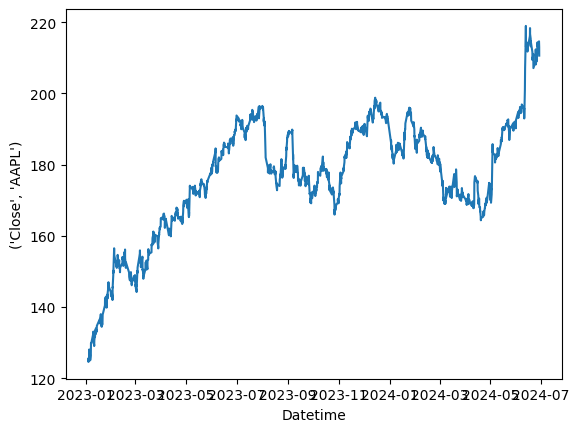

In [194]:
history = data.fetch_yahoo_history(interval="1h")
history.index = history.index.tz_convert("UTC").tz_localize(None)

history_column = ("Close", "AAPL")
seaborn.lineplot(history.loc[:, history_column])

23:02:04 - cmdstanpy - INFO - Chain [1] start processing
23:02:05 - cmdstanpy - INFO - Chain [1] done processing


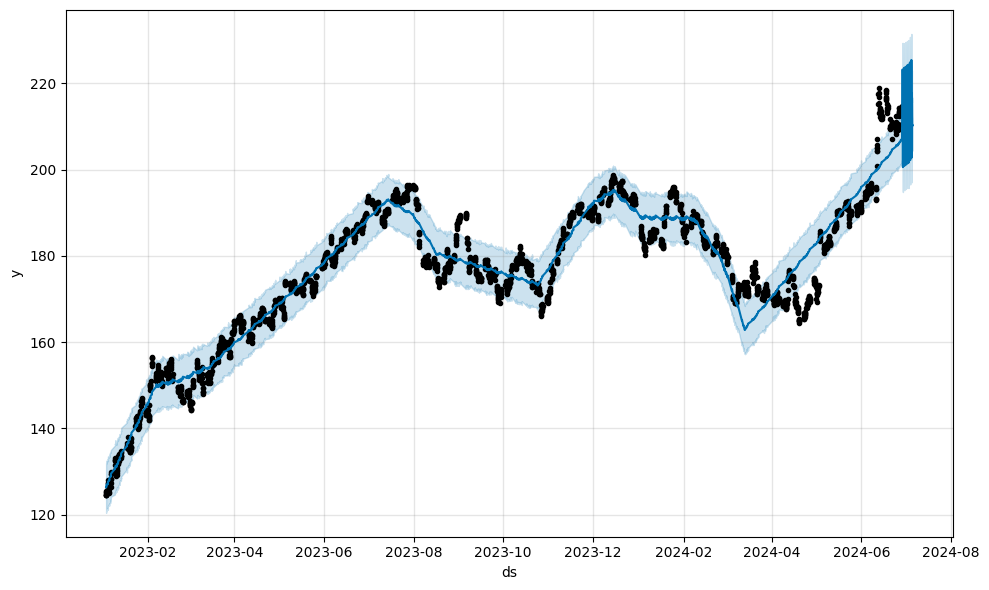

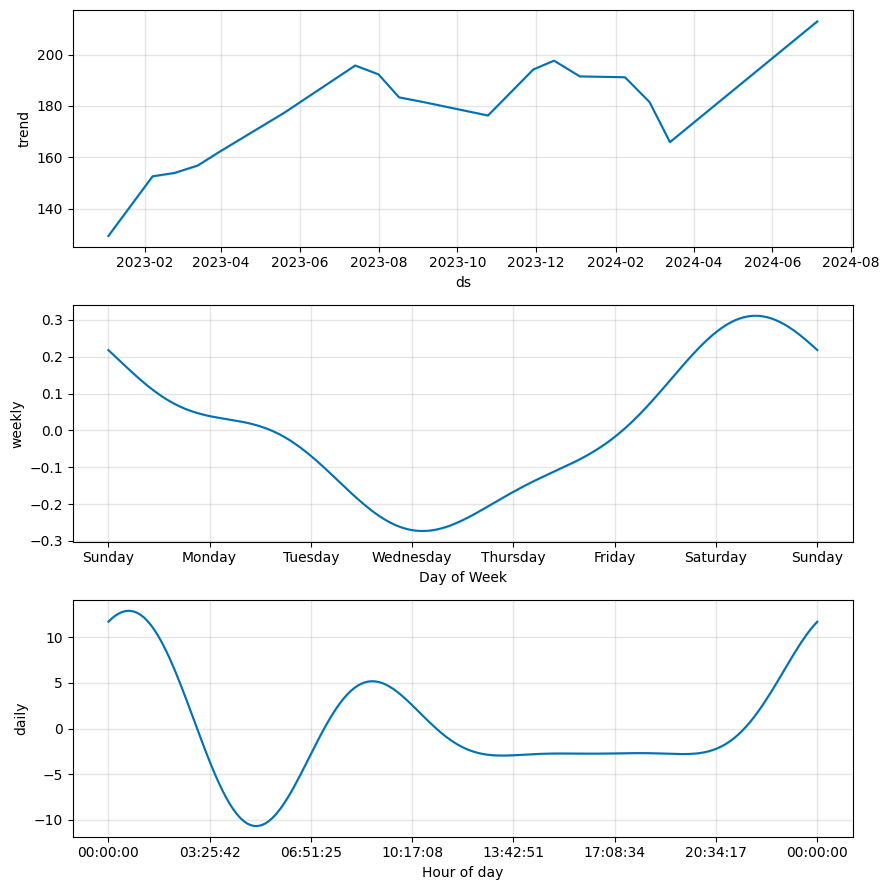

In [176]:
prophet_df = pd.DataFrame(
    {"ds": history.index, "y": history.loc[:, history_column].values}
)
prophet_model = prophet.Prophet()
prophet_model.fit(prophet_df)
prophet_future_df = prophet_model.make_future_dataframe(periods=24 * 7, freq="h")
prophet_predictions = prophet_model.predict(prophet_future_df)
prophet_model.plot(prophet_predictions)
prophet_model.plot_components(prophet_predictions);

Inferred granularity 0 days 01:00:00


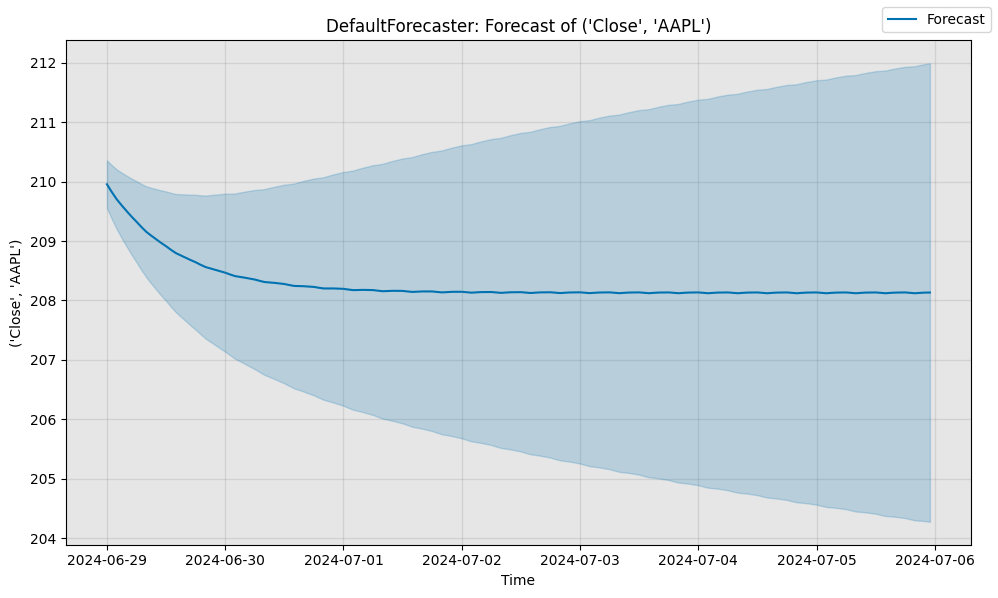

In [227]:
merlion_model = merlion.models.defaults.DefaultForecaster(
    merlion.models.defaults.DefaultForecasterConfig()
)
time_series = merlion.utils.TimeSeries.from_pd(history.loc[:, history_column])
merlion_model.train(time_series)
prediction_range = pd.date_range(
    start=datetime.date.today(), periods=24 * 7, freq="h"
).values
pred, pred_err = merlion_model.forecast(prediction_range)
merlion_model.plot_forecast(
    time_stamps=prediction_range, plot_forecast_uncertainty=True
);